# Introduction: Term Deposit Subscription Prediction

## Objective: Predict whether a bank customer will subscribe to a term deposit as a result of a marketing campaign

### Objective 1: Import Libraries

In [15]:
# ===============================
# STEP 1: Import Required Libraries
# ===============================
import pandas as pd
import numpy as np
import requests
import zipfile
import io
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_recall_curve, roc_curve, auc, accuracy_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

import lime
import lime.lime_tabular
from IPython.display import display

warnings.filterwarnings("ignore")
print("✅ Libraries imported successfully.")

✅ Libraries imported successfully.


### Objective 2: Load dataset

In [16]:
# ===============================
# STEP 2: Load Dataset
# ===============================
zip_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
r = requests.get(zip_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
file_name = "bank-additional/bank-additional.csv"

with z.open(file_name) as f:
    df = pd.read_csv(f, sep=';')

print("✅ Dataset loaded successfully!")
print("📌 First 5 rows:")
display(df.head())

✅ Dataset loaded successfully!
📌 First 5 rows:


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


### Objective 3: Explore dataset

In [17]:
#Shape Of Dataset
print("📌 Shape:", df.shape)

📌 Shape: (4119, 21)


In [18]:
import io

print("=== Dataset Information ===")
buf = io.StringIO()
df.info(buf=buf)
info_str = buf.getvalue()
print(info_str)

=== Dataset Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.

In [19]:
print("\n📌 Output: Missing Values in Each Column")
print(df.isnull().sum())


📌 Output: Missing Values in Each Column
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


### Objective 4: Feature & Target Split

In [20]:
# 📌 Splitting features (X) and target (y)
X = df.drop("y", axis=1)   # Features
y = df["y"].map({"yes": 1, "no": 0})   # Target (manually encoded yes→1, no→0)

print("=== Features (X) Preview ===")
display(X.head()) 

print("\n=== Target (y) Preview ===")
print(y.head().to_frame().rename(columns={"y": "Target"}))

=== Features (X) Preview ===


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8



=== Target (y) Preview ===
   Target
0       0
1       0
2       0
3       0
4       0


### Objective 5: Identify Column Types

In [21]:
# Identifying categorical & numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print("=== Column Types ===")
print(f"Categorical Columns ({len(categorical_cols)}):")
for col in categorical_cols:
    print(f"  - {col}")

print(f"\nNumerical Columns ({len(numerical_cols)}):")
for col in numerical_cols:
    print(f"  - {col}")

=== Column Types ===
Categorical Columns (10):
  - job
  - marital
  - education
  - default
  - housing
  - loan
  - contact
  - month
  - day_of_week
  - poutcome

Numerical Columns (10):
  - age
  - duration
  - campaign
  - pdays
  - previous
  - emp.var.rate
  - cons.price.idx
  - cons.conf.idx
  - euribor3m
  - nr.employed


### Objective 6: Define Transformers

In [22]:
# Defining transformers (encoding & scaling)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numerical_transformer = StandardScaler()

print("=== Transformers Defined ===")
print("OneHotEncoder will be applied to categorical columns:")
for col in categorical_cols:
    print(f"  - {col}")

print("\nStandardScaler will be applied to numerical columns:")
for col in numerical_cols:
    print(f"  - {col}")

=== Transformers Defined ===
OneHotEncoder will be applied to categorical columns:
  - job
  - marital
  - education
  - default
  - housing
  - loan
  - contact
  - month
  - day_of_week
  - poutcome

StandardScaler will be applied to numerical columns:
  - age
  - duration
  - campaign
  - pdays
  - previous
  - emp.var.rate
  - cons.price.idx
  - cons.conf.idx
  - euribor3m
  - nr.employed


### Objective 7: Define Preprocessor

In [23]:
# Defining the ColumnTransformer (encoding/scaling setup)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

print("✅ Preprocessor defined (but not applied yet)")

✅ Preprocessor defined (but not applied yet)


### Objective 8: Train/Test Split

In [27]:
# Splitting dataset into Train/Test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Train feature shape:", X_train.shape)
print("✅ Test feature shape:", X_test.shape)

✅ Train feature shape: (3295, 20)
✅ Test feature shape: (824, 20)


In [28]:
# 📌 Checking target distribution after split
print("\n📌 Train Target Distribution:\n", y_train.value_counts())
print("\n📌 Test Target Distribution:\n", y_test.value_counts())


📌 Train Target Distribution:
 y
0    2934
1     361
Name: count, dtype: int64

📌 Test Target Distribution:
 y
0    734
1     90
Name: count, dtype: int64


### Objective 9: Logistic Regression - Model Setup

In [29]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# ================================
# Step 4: Logistic Regression with SMOTE + Tuning
# ================================

# Build pipeline with preprocessing + SMOTE + classifier
log_reg_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

# Baseline model training
log_reg_pipeline.fit(X_train, y_train)
train_acc_lr = log_reg_pipeline.score(X_train, y_train)
test_acc_lr = log_reg_pipeline.score(X_test, y_test)

print("✅ Logistic Regression (with SMOTE) trained successfully!")
print(f"✅ Train Accuracy: {train_acc_lr:.4f}")
print(f"✅ Test Accuracy: {test_acc_lr:.4f}")

✅ Logistic Regression (with SMOTE) trained successfully!
✅ Train Accuracy: 0.8762
✅ Test Accuracy: 0.8811


### Objective 10: After Tuning Accuracy

In [30]:
# Hyperparameter tuning with GridSearch
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [500, 1000]
}

grid_search = GridSearchCV(estimator=log_reg_pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best tuned model
best_log_reg_pipeline = grid_search.best_estimator_
train_acc_lr_tuned = best_log_reg_pipeline.score(X_train, y_train)
test_acc_lr_tuned = best_log_reg_pipeline.score(X_test, y_test)

print("✅ Tuned Logistic Regression Model Successfully!")
print(f"🔹 Best Parameters: {grid_search.best_params_}")
print(f"✅ Tuned Train Accuracy: {train_acc_lr_tuned:.4f}")
print(f"✅ Tuned Test Accuracy: {test_acc_lr_tuned:.4f}")

✅ Tuned Logistic Regression Model Successfully!
🔹 Best Parameters: {'classifier__C': 1, 'classifier__max_iter': 500, 'classifier__solver': 'liblinear'}
✅ Tuned Train Accuracy: 0.8768
✅ Tuned Test Accuracy: 0.8811


### Objective 11: Prediction Of Logistic Model

In [20]:
# Logistic Regression Predictions
y_pred_lr = log_reg_pipeline.predict(X_test)
y_prob_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]

print("📌 Logistic Regression Results @ Threshold 0.5")
print(classification_report(y_test, y_pred_lr))

📌 Logistic Regression Results @ Threshold 0.5
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       734
           1       0.46      0.83      0.59        90

    accuracy                           0.88       824
   macro avg       0.72      0.86      0.76       824
weighted avg       0.92      0.88      0.89       824



### Objective 12: Evaluation matrics oF Logistic Regression

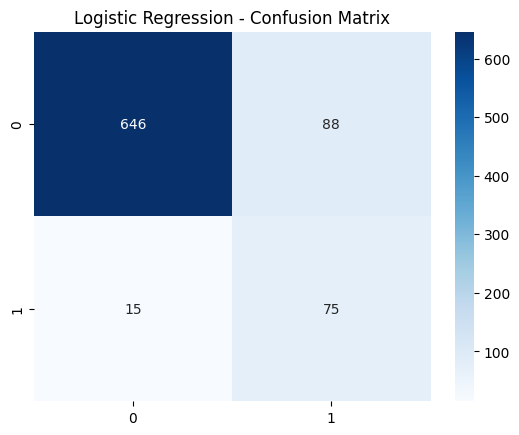

✅ Confusion Matrix displayed above


In [21]:
# Confusion Matrix - Logistic Regression
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix")
plt.show()
print("✅ Confusion Matrix displayed above")

In [22]:
# Threshold Tuning - Logistic Regression
prec, rec, thresh = precision_recall_curve(y_test, y_prob_lr)
f1s = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = np.argmax(f1s)
best_thresh_lr = thresh[best_idx]
best_f1_lr = f1s[best_idx]

print(f"[LogReg] Best Threshold: {best_thresh_lr:.3f}, Best F1: {best_f1_lr:.4f}")

[LogReg] Best Threshold: 0.580, Best F1: 0.6174


In [23]:
# Logistic Regression - Optimal Threshold
y_pred_lr_opt = (y_prob_lr >= best_thresh_lr).astype(int)
print("📌 Logistic Regression @ Optimal Threshold")
print(classification_report(y_test, y_pred_lr_opt))

📌 Logistic Regression @ Optimal Threshold
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       734
           1       0.51      0.79      0.62        90

    accuracy                           0.89       824
   macro avg       0.74      0.85      0.78       824
weighted avg       0.92      0.89      0.90       824



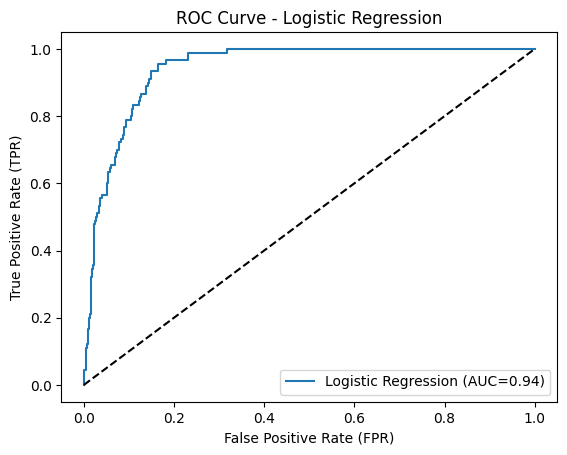

✅ ROC Curve displayed above | AUC = 0.94


In [24]:
# ROC Curve - Logistic Regression
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"Logistic Regression (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()
print(f"✅ ROC Curve displayed above | AUC = {roc_auc:.2f}")

### Objective 13: Define & Fit Random Forest

In [25]:
# STEP 5: Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200, 
        class_weight="balanced", 
        random_state=42
    ))
])

# Fit model
rf_pipeline.fit(X_train, y_train)
print("=== Random Forest model trained successfully ===")

=== Random Forest model trained successfully ===


### Objective 14: Train & Test Accuracy

In [26]:
# Predictions for accuracy calculation
y_pred_rf_train = rf_pipeline.predict(X_train)
y_pred_rf = rf_pipeline.predict(X_test)

train_acc_rf = accuracy_score(y_train, y_pred_rf_train)
test_acc_rf = accuracy_score(y_test, y_pred_rf)

print("=== Random Forest Accuracy ===")
print(f"Train Accuracy: {train_acc_rf:.4f}")
print(f"Test Accuracy : {test_acc_rf:.4f}")

=== Random Forest Accuracy ===
Train Accuracy: 1.0000
Test Accuracy : 0.9078


### Objective 15: Classification Report & Confusion Matrix

=== Random Forest Results @ Threshold = 0.5 ===
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       734
           1       0.73      0.24      0.37        90

    accuracy                           0.91       824
   macro avg       0.82      0.62      0.66       824
weighted avg       0.89      0.91      0.89       824



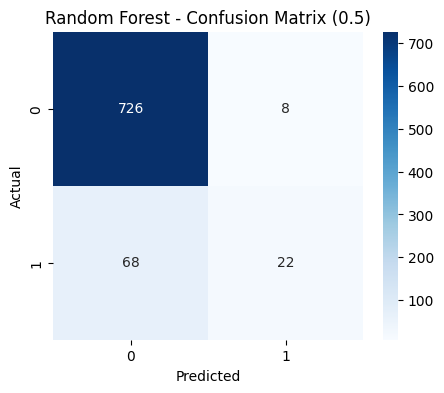

In [27]:
print("=== Random Forest Results @ Threshold = 0.5 ===")
print(classification_report(y_test, y_pred_rf))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest - Confusion Matrix (0.5)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Objective 16: Threshold Tuning for Best F1

In [28]:
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

prec_rf, rec_rf, thresh_rf = precision_recall_curve(y_test, y_prob_rf)
f1s_rf = (2 * prec_rf[:-1] * rec_rf[:-1]) / (prec_rf[:-1] + rec_rf[:-1] + 1e-12)

best_idx_rf = np.argmax(f1s_rf)
best_thresh_rf = thresh_rf[best_idx_rf]
best_f1_rf = f1s_rf[best_idx_rf]

print("=== Random Forest Optimal Threshold ===")
print(f"Best Threshold: {best_thresh_rf:.3f}")
print(f"Best F1 Score : {best_f1_rf:.4f}")

# Predictions with optimal threshold
y_pred_rf_opt = (y_prob_rf >= best_thresh_rf).astype(int)
print("\nClassification Report @ Optimal Threshold")
print(classification_report(y_test, y_pred_rf_opt))

=== Random Forest Optimal Threshold ===
Best Threshold: 0.140
Best F1 Score : 0.6103

Classification Report @ Optimal Threshold
              precision    recall  f1-score   support

           0       0.99      0.87      0.92       734
           1       0.46      0.92      0.61        90

    accuracy                           0.87       824
   macro avg       0.72      0.89      0.77       824
weighted avg       0.93      0.87      0.89       824



### Objective 17: ROC Curve

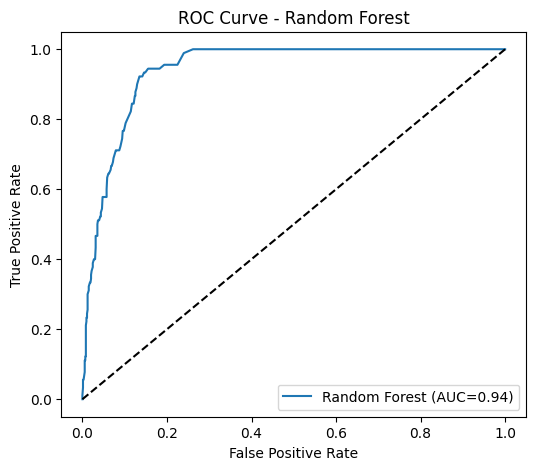

In [29]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

### Objective 18: Preprocess Data for LIME

In [30]:
# Preprocess train/test data (convert to numeric)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert sparse to dense if necessary
X_train_dense = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else np.asarray(X_train_processed)
X_test_dense = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else np.asarray(X_test_processed)

# Get feature names
feature_names = preprocessor.get_feature_names_out()

print("=== Data Prepared for LIME ===")
print(f"Training samples: {X_train_dense.shape}")
print(f"Test samples    : {X_test_dense.shape}")
print(f"Total features  : {len(feature_names)}")

=== Data Prepared for LIME ===
Training samples: (3295, 63)
Test samples    : (824, 63)
Total features  : 63


### Objective 19: Define LIME Explainer

In [32]:
# Define LIME explainer
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(
    training_data=X_train_dense,
    feature_names=feature_names,
    class_names=["No", "Yes"],
    mode="classification"
)

# Wrapper for Random Forest classifier
def rf_predict_proba(x):
    return rf_pipeline.named_steps["classifier"].predict_proba(x)

print("=== LIME Explainer Defined ===")
print(f"Mode           : Classification")
print(f"Class names    : {explainer.class_names}")
print(f"Sample feature : {feature_names[:5]} ...")

=== LIME Explainer Defined ===
Mode           : Classification
Class names    : ['No', 'Yes']
Sample feature : ['num__age' 'num__duration' 'num__campaign' 'num__pdays' 'num__previous'] ...


### Objective 20: Generate Explanation for One Instance

In [33]:
# Pick a test instance
i = 10

# Generate explanation
exp = explainer.explain_instance(
    X_test_dense[i],
    rf_predict_proba,
    num_features=10
)

print(f"=== LIME Explanation Generated ===")
print(f"Test instance index: {i}")
print(f"Top {10} contributing features shown in visualization below")

=== LIME Explanation Generated ===
Test instance index: 10
Top 10 contributing features shown in visualization below


### Objective 21: Visualize Explanation

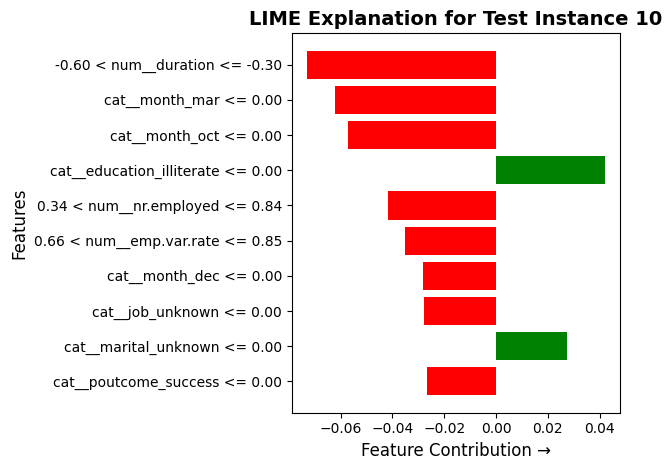

In [34]:
# Visualization
fig = exp.as_pyplot_figure(label=1)  # label=1 = "Yes"
plt.title(f"LIME Explanation for Test Instance {i}", fontsize=14, weight="bold")
plt.xlabel("Feature Contribution →", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

### Objective 22: Structured Feature Contribution Table

In [35]:
# Convert explanation into a table
exp_features = exp.as_list(label=1)   # label=1 = "Yes"
lime_df = pd.DataFrame(exp_features, columns=["Feature", "Contribution"])

print("=== LIME Feature Contributions ===")
display(lime_df)

=== LIME Feature Contributions ===


,Feature,Contribution
0,-0.60 < num__duration <= -0.30,-0.073131
1,cat__month_mar <= 0.00,-0.061967
2,cat__month_oct <= 0.00,-0.057112
3,cat__education_illiterate <= 0.00,0.042109
4,0.34 < num__nr.employed <= 0.84,-0.041729
5,0.66 < num__emp.var.rate <= 0.85,-0.035078
6,cat__month_dec <= 0.00,-0.028316
7,cat__job_unknown <= 0.00,-0.027822
8,cat__marital_unknown <= 0.00,0.027412
9,cat__poutcome_success <= 0.00,-0.026677
